In [20]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [21]:
class GaussianDataset(Dataset):
    def __init__(self, file_path=None, num_samples=100, seed=42, cov= 0.3):
        if file_path is not None:
            self.data = pd.read_csv(file_path)
            self.labels = torch.tensor(self.data.iloc[:, -1], dtype=torch.long)
        else:
            np.random.seed(seed)
            # class1_mean = [1, 0]
            # class1_cov = [[cov, 0], [0, cov]]
            # class2_mean = [0, -1]
            # class2_cov = [[cov, 0], [0, cov]]
            # class3_mean = [-1, 0]
            # class3_cov = [[cov, 0], [0, cov]]
            # class4_mean = [-1, -1]
            # class4_cov = [[cov, 0], [0, cov]]
            class1_mean = [0.5, 0.5]
            class1_cov = [[cov, 0], [0, cov]]
            class2_mean = [-0.5, -0.5]
            class2_cov = [[cov, 0], [0, cov]]
            class3_mean = [-1, 0]
            class3_cov = [[cov, 0], [0, cov]]
            class4_mean = [-1, -1]
            class4_cov = [[cov, 0], [0, cov]]
            class1_data = np.random.multivariate_normal(class1_mean, class1_cov, num_samples)
            class2_data = np.random.multivariate_normal(class2_mean, class2_cov, num_samples)
            class3_data = np.random.multivariate_normal(class3_mean, class3_cov, num_samples)
            class4_data = np.random.multivariate_normal(class4_mean, class4_cov, 0)


            class1_labels = np.zeros(num_samples)
            class2_labels = np.ones(num_samples)
            class3_labels = np.zeros(num_samples)
            class4_labels = np.ones(0)



            data = np.concatenate([class1_data, class2_data, class3_data, class4_data], axis=0)
            labels = np.concatenate([class1_labels, class2_labels, class3_labels, class4_labels])

            self.data = pd.DataFrame(data, columns=['feature1', 'feature2'])
            self.data['label'] = labels.astype(int)

            self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        features = torch.tensor(self.data.iloc[idx, :-1].values, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return features, label

    def save_to_csv(self, file_path):
        self.data.to_csv(file_path, index=False)

In [22]:
# Example usage:
from_file = False
cov = 0.2
n_samples = 50
file_path = '/vol/aimspace/users/kaiserj/Individual_Privacy_Accounting/mimic_experiments/Datasets/gaussian_dataset.csv'

if from_file:
    dataset = GaussianDataset(file_path=file_path, cov=cov, num_samples=n_samples)
else:
    dataset = GaussianDataset(file_path=None, cov=cov, num_samples=n_samples)
    dataset.save_to_csv(file_path)
df = dataset.data  # Assuming you already have the dataset loaded

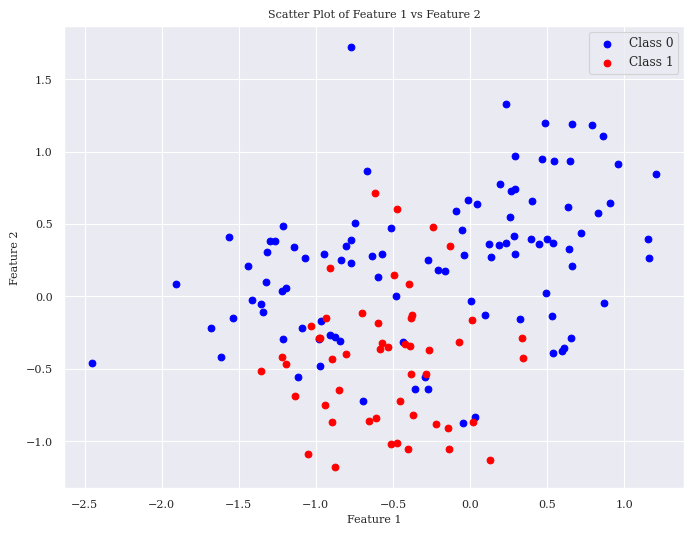

In [23]:
df = dataset.data  # Assuming you already have the dataset loaded

# Separate data points based on labels
class1 = df[df['label'] == 0]
class2 = df[df['label'] == 1]

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(class1['feature1'], class1['feature2'], color='blue', label='Class 0')
plt.scatter(class2['feature1'], class2['feature2'], color='red', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Feature 1 vs Feature 2')
plt.legend()
plt.grid(True)

# Save the plot
plt.show()

In [24]:
delta = 0.003
alpha = 1.00
a = 100
def loss_norm(w2, w1):
    return delta * (torch.sqrt(( w1**2) + (w2**2)) - a*torch.exp(-(w1 + w2**2)**2)) # delta  *torch.sqrt(w1**2 + w2**2) # 

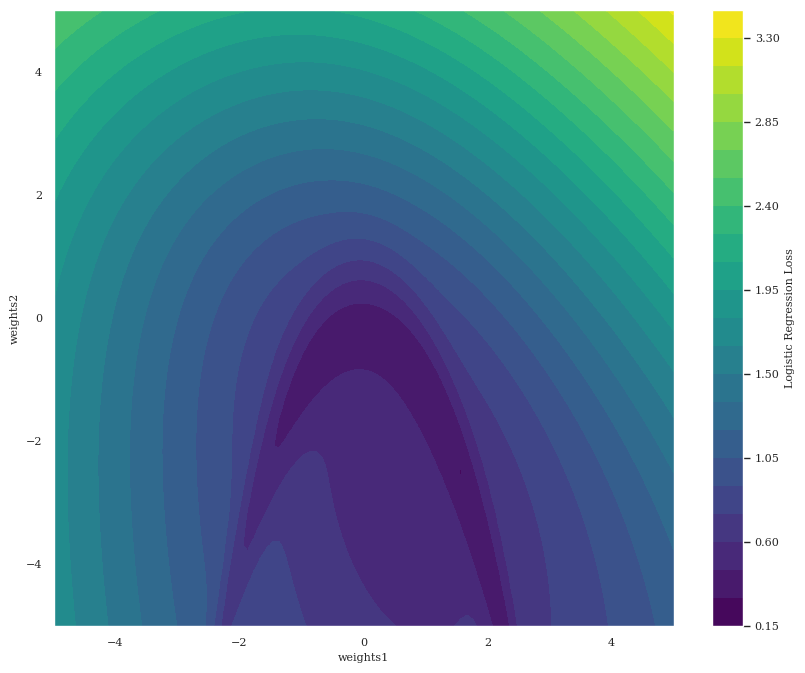

In [25]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logistic_regression_loss(weights, bias, features, labels):
    scores = torch.matmul(features, weights) + bias
    preds = sigmoid(scores)
    test1 = torch.multiply(labels,  np.log(preds))
    loss = -torch.mean(torch.multiply(labels,  np.log(preds)) + torch.multiply((1 - labels), np.log(1 - preds)))
    return loss

# Generate some random weights and bias
weights1 = torch.linspace(-5, 5, 100)
weights2 = torch.linspace(-5, 5, 100)

bias = torch.zeros(len(weights1))
losses = torch.zeros((len(weights1), len(weights2)))

# Assuming you have your dataset loaded into features and labels
features = torch.tensor(dataset.data.iloc[:, :-1].values).type(torch.float32)
labels = torch.tensor(dataset.labels).type(torch.float32)

for i, w1 in enumerate(weights1):
    for j, w2 in enumerate(weights2):
        losses[i, j] = alpha * logistic_regression_loss(torch.stack([w1, w2]), 0, features, labels) + loss_norm(w1, w2)

# Plot the loss
fig1, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(weights1, weights2, losses.T, levels=20, cmap='viridis')
plt.colorbar(contour, label='Logistic Regression Loss', ax=ax)
ax.set_xlabel('weights1')
ax.set_ylabel('weights2')
ax.grid(True)
# plt.show()

def loss_fct(model, out, labels):
    criterion = torch.nn.BCELoss()

    w = list(model.parameters())
    w1 = w[0][0][0]
    w2 = w[0][0][1]
    return alpha * criterion(out, labels) + loss_norm(w1, w2)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1, bias=False)


    def forward(self, x):
        return torch.sigmoid(self.linear(x))

def train_model(features, labels, epochs=100, lr=0.01, reg=0, seed=None):
    torch.manual_seed(seed)
    input_size = features.shape[1]
    model = LogisticRegression(input_size)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=reg)

    for epoch in range(epochs):
        inputs = features
        targets = labels

        optimizer.zero_grad()
        outputs = model(inputs)
        w = list(model.parameters())
        w1 = w[0][0][0]
        w2 = w[0][0][1]
        loss = criterion(outputs.squeeze(), targets) + loss_norm(w1, w2) # delta * (w1**2 * w2**2)

        loss.backward()
        optimizer.step()

    return model, loss

def get_loss(model, features, labels, norm=True):
    criterion = nn.BCELoss()
    inputs = features
    targets = labels
    outputs = model(inputs)
    w = list(model.parameters())
    w1 = w[0].data[0][0]
    w2 = w[0].data[0][1]
    if norm:
        loss = criterion(outputs.squeeze(), targets) + loss_norm(w1, w2)
    else:
        loss = criterion(outputs.squeeze(), targets)
    return loss

In [27]:
from torch.func import hessian as hessian_fct
from scipy.special import expit

def hessian_own(weights, bias, features, labels, loss):
    weights = weights
    features = features
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # def logistic_regression_loss(weights, bias, features, labels):
    #     scores = np.dot(features, weights) + bias
    #     preds = sigmoid(scores)
    #     loss = -np.mean(labels * np.log(preds) + (1 - labels) * np.log(1 - preds))
    #     return loss
        
    # hess = hessian_fct(logistic_regression_loss, argnums=0)(weights, bias, features, labels)
    z = features @ weights.T
    D = sigmoid(z) * (1-sigmoid(z))
    D = torch.diag(D.squeeze())
    hess = features.T @ D @ features
    hess = 1/D.shape[0] * hess
    w1 = weights[0]
    w2 = weights[1]
    # dw1w1 = 2 * w2**2
    # dw2w2 = 2 * w1**2
    # dw1w2 = 4 * w1 * w2

    # hess_reg = delta * torch.tensor([[dw1w1, dw1w2],  [dw1w2, dw2w2]])


    hess_reg = torch.autograd.functional.hessian(loss_norm, (w1, w2))

    # z = (w1 + w2**2)
    # dw1w1 = -4 * a * z**2 * 2.7**(-z**2) + 2 * a * 2.7**(-z**2) + 2
    # dw1w2 = -4 * a * w2 * (2 * w2**4 + 4* w1 * w2**2 + 2 * w1**2 - 1) * 2.7**(-z**2)
    # dw2w2 = -4 * a * (4 * w2**6 + 8 * w1 * w2**4 + (4*w1**2 - 3) * w2**2 - w1) * 2.7**(-z**2)
    # hess_reg = delta * np.array([[dw1w1, dw1w2], [dw1w2, dw2w2]])

    hess = torch.add(hess, torch.tensor(hess_reg))
    
    return hess

In [28]:
import sys
sys.path.append("/vol/aimspace/users/kaiserj/Individual_Privacy_Accounting/mimic_experiments")
import torch
from functorch import grad, jvp, make_functional, vjp, make_functional_with_buffers, hessian, jacfwd, jacrev, vmap
from functools import partial
from utils.functorch_utils import get_params_structure, stack_gradient, custum_hvp, stack_gradient2, stack_gradient3
from torch.distributions import Normal
from torch import nn
import numpy as np
import math
import time
import copy

class binary_cross_entropy_manifold:
    """
    Also in this case I have to split the gradient loss computation and the gradient of the regularization
    term.
    This is needed to get the correct gradient and hessian computation when using batches.
    """

    def __init__(
        self, model, X, y, batching=False, device="cpu", lambda_reg=None, type="fc", N=None, B1=None, B2=None
    ):
        self.model = model

        self.X = X
        self.y = y
        self.N = len(self.X)
        self.n_params = len(torch.nn.utils.parameters_to_vector(self.model.parameters()))
        self.batching = batching
        self.device = device
        self.type = type
        # self.prior_precision = prior_precision
        self.lambda_reg = lambda_reg
        assert y is None if batching else True, "If batching is True, y should be None"

        # these are just to avoid to have to pass them as input of the functions
        # we use to compute the gradient and the hessian vector product
        self.fmodel = None
        self.buffers = None

        ## stuff we need when using barches
        self.N = N
        self.B1 = B1
        self.B2 = B2
        self.factor = None

        # here I can already compute the factor_loss
        if self.B1 is not None:
            self.factor = N / B1
            if self.B2 is not None:
                self.factor = self.factor * (B2 / B1)

    @staticmethod
    def is_diagonal():
        return False

    def BCE_loss(self, param, data):
        """
        Data fitting term of the loss
        """
        x, y = data
        x = x.to(self.device).type(torch.float32)
        y = y.to(self.device).type(torch.float32)

        if self.type != "fc":
            # assuming input for con
            x = x.unsqueeze(1)

        if self.model is None:
            raise NotImplementedError("Compute usual prediction still have to be implemented")
        else:
            # self.fmodel.eval()
            y_pred = self.fmodel(param, self.buffers, x)
        y_pred = y_pred.squeeze()
        y = y.squeeze()
        criterion = torch.nn.BCELoss(reduction="sum")

        if self.type == "fc":
            if self.factor is not None:
                return self.factor * criterion(y_pred, y)
            else:
                return criterion(y_pred, y)
        else:
            if self.factor is not None:
                return self.factor * criterion(y_pred.view(-1), y)
            else:
                return criterion(y_pred.view(-1), y)

    def L2_norm(self, param):
        """
        L2 regularization. I need this separate from the loss for the gradient computation
        """
        w_norm = sum([sum(w.view(-1) ** 2) for w in param])
        return self.lambda_reg * w_norm
    
    def own_norm(self, param):
        """
        L2 regularization. I need this separate from the loss for the gradient computation
        """
        w1 = param[0][0][0]
        w2 = param[0][0][1]
        return loss_norm(w1, w2)

    def compute_grad_data_fitting_term(self, params, data):
        # TODO: understand how to make vmap work without passing the data
        ft_compute_grad = grad(self.BCE_loss)
        # ft_compute_sample_grad = vmap(ft_compute_grad, in_dims=(None, 0))
        # the input of this function is just the parameters, because
        # we are accessing the data from the class
        ft_per_sample_grads = ft_compute_grad(params, data)
        return ft_per_sample_grads

    def compute_grad_L2_reg(self, params):
        ft_compute_grad = grad(self.L2_norm)

        ft_per_sample_grads = ft_compute_grad(params)
        return ft_per_sample_grads
    

    def compute_grad_own_reg(self, params):
        ft_compute_grad = grad(self.own_norm)

        ft_per_sample_grads = ft_compute_grad(params)
        return ft_per_sample_grads

    def geodesic_system(self, current_point, velocity, return_hvp=False):
        # check if they are numpy array or torch.Tensor
        # here we need torch tensor to perform these operations
        if not isinstance(current_point, torch.Tensor):
            current_point = torch.from_numpy(current_point).float().to(self.device)

        if not isinstance(velocity, torch.Tensor):
            velocity = torch.from_numpy(velocity).float().to(self.device)

        # I would expect both current point and velocity to be
        # two vectors of shape n_params
        if isinstance(self.X, torch.utils.data.DataLoader):
            batchify = True
        else:
            batchify = False
            data = (self.X, self.y)

        # let's start by putting the current points into the model
        torch.nn.utils.vector_to_parameters(current_point, self.model.parameters())

        self.model.zero_grad()

        self.fmodel, params, self.buffers = make_functional_with_buffers(self.model)

        # and I have to reshape the velocity into being the same structure as the params
        vel_as_params = get_params_structure(velocity, params)

        # now I have everything to compute the the second derivative
        # let's compute the gradient
        start = time.time()
        grad_data_fitting_term = 0
        if batchify:
            for batch_img, batch_label in self.X:
                grad_per_example = self.compute_grad_data_fitting_term(params, (batch_img, batch_label))
                grad_data_fitting_term += stack_gradient3(grad_per_example, self.n_params).view(-1, 1)
        else:
            grad_per_example = self.compute_grad_data_fitting_term(params, data)
            gradw = stack_gradient3(grad_per_example, self.n_params)
            grad_data_fitting_term = gradw.view(-1, 1)
        end = time.time()

        # now I have to compute the gradient of the regularization term
        if self.lambda_reg is not None:
            # I have to compute the L2 reg gradient
            grad_reg = self.compute_grad_own_reg(params)
            grad_reg = stack_gradient3(grad_reg, self.n_params)
            grad_reg = grad_reg.view(-1, 1)
        else:
            grad_reg = 0

        tot_gradient = grad_data_fitting_term + grad_reg

        # now I have also to compute the Hvp between hessian and velocity
        start = time.time()
        if batchify:
            hvp_data_fitting = 0
            for batch_img, batch_label in self.X:
                if self.type == "fc":
                    _, result = custum_hvp(
                        self.BCE_loss,
                        (params, (batch_img, batch_label)),
                        (vel_as_params, (torch.zeros_like(batch_img), torch.zeros_like(batch_label))),
                    )
                else:
                    print("If you are getting an error, before here I was using self.CE_loss2, so double check that")
                    _, result = custum_hvp(
                        self.BCE_loss,
                        (params, (batch_img, batch_label)),
                        (vel_as_params, (torch.zeros_like(batch_img), torch.zeros_like(batch_label))),
                    )
                hvp_data_fitting += torch.cat([sub_prod.flatten() for sub_prod in result])
        else:
            _, result = custum_hvp(
                self.BCE_loss, (params, data), (vel_as_params, (torch.zeros_like(data[0]), torch.zeros_like(data[1])))
            )
            hvp = [sub_prod.flatten() for sub_prod in result]
            hvp_data_fitting = torch.cat(hvp)

        if self.lambda_reg is not None:
            hvp_reg = 2 * self.lambda_reg * velocity
            tot_hvp = hvp_data_fitting + hvp_reg.view(-1)
        else:
            tot_hvp = hvp_data_fitting

        tot_hvp = tot_hvp.to(self.device)
        tot_gradient = tot_gradient.to(self.device)
        end = time.time()

        second_derivative = -((tot_gradient / (1 + tot_gradient.T @ tot_gradient)) * (velocity.T @ tot_hvp)).flatten()

        if return_hvp:
            return second_derivative.view(-1, 1).detach().cpu().numpy(), tot_hvp.view(-1, 1).detach().cpu().numpy()
        else:
            return second_derivative.view(-1, 1).detach().cpu().numpy()

    def get_gradient_value_in_specific_point(self, current_point):
        if isinstance(self.X, torch.utils.data.DataLoader):
            batchify = True
        else:
            batchify = False
            data = (self.X, self.y)

        # method to return the gradient of the loss in a specific point
        if not isinstance(current_point, torch.Tensor):
            current_point = torch.from_numpy(current_point).float()

        current_point = current_point.to(self.device)
        assert (
            len(current_point) == self.n_params
        ), "You are passing a larger vector than the number of weights in the model"
        self.model.zero_grad()

        self.fmodel, params, self.buffers = make_functional_with_buffers(self.model)

        grad_data_fitting_term = 0
        if self.batching:
            for batch_img, batch_label in self.X:
                grad_per_example = self.compute_grad_data_fitting_term(params, (batch_img, batch_label))
                grad_data_fitting_term += stack_gradient3(grad_per_example, self.n_params).view(-1, 1)
        else:
            data = (self.X, self.y)
            grad_per_example = self.compute_grad_data_fitting_term(params, data)

            gradw = stack_gradient3(grad_per_example, self.n_params)
            grad_data_fitting_term = gradw.view(-1, 1)

        # now I have to compute the regularization term
        if self.lambda_reg is not None:
            # I have to compute the L2 reg gradient
            grad_reg = self.compute_grad_own_reg(params)
            grad_reg = stack_gradient3(grad_reg, self.n_params)
            grad_reg = grad_reg.view(-1, 1)
        else:
            grad_reg = 0

        tot_gradient = grad_data_fitting_term + grad_reg
        tot_gradient = tot_gradient.to(self.device)

        return tot_gradient

In [29]:
import torch
import numpy as np

from laplace import Laplace
import utils.geometry as geometry
from torch import nn
from torch.distributions import MultivariateNormal
from tqdm import tqdm
from copy import deepcopy


def riemann(device, 
         seed, 
         x_train, 
         y_train, 
         trained_model, 
         initial_model, 
         subset_of_weights, 
         optimize_prior, 
         hessian_structure,
         weight_decay,
         n_last_layer_weights,
         n_posterior_samples,
         batch_data,
         std=None):
    

    np.random.seed(seed)
    torch.manual_seed(seed)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(x_train), shuffle=False)


    model = trained_model

    # at the end of the training I can get the map solution
    map_solution = torch.nn.utils.parameters_to_vector(model.parameters()).detach().clone()

    torch.nn.utils.vector_to_parameters(map_solution, model.parameters())


    if std is None:
        la = Laplace(
            model,
            "classification",
            subset_of_weights=subset_of_weights,
            hessian_structure=hessian_structure,
            prior_precision=2 * weight_decay,
        )
        la.fit(train_loader)
    else:
        class LA:
            def __init__(self, n_params, posterior_scale):
                self.n_params = n_params
                self.posterior_scale = torch.tensor(posterior_scale)
        la = LA(std.shape[0], std)


    if optimize_prior:
        la.optimize_prior_precision(method="marglik")
    if optimize_prior:
        print("Prior precision we are using")
        print(la.prior_precision)

    # and get some samples from it, our initial velocities
    # now I can get some samples for the Laplace approx
    if subset_of_weights == "last_layer":
        if hessian_structure == "diag":
            n_last_layer_weights = n_last_layer_weights
            # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            samples = torch.randn(n_posterior_samples, la.n_params, device=device).detach()
            samples = samples * la.posterior_scale.reshape(1, la.n_params)
            V_LA = samples.detach().numpy()
        else:
            n_last_layer_weights = n_last_layer_weights
            dist = MultivariateNormal(loc=torch.zeros(n_last_layer_weights), covariance_matrix=la.posterior_scale @ la.posterior_scale)
            V_LA = dist.sample((n_posterior_samples,))
            V_LA = V_LA.detach().numpy()
    else:
        if hessian_structure == "diag":
            # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            samples = torch.randn(n_posterior_samples, la.n_params, device=device).detach()
            samples = samples * la.posterior_scale.reshape(1, la.n_params)
            V_LA = samples.detach().numpy()

        else:
            dist = MultivariateNormal(loc=torch.zeros_like(map_solution), covariance_matrix=(la.posterior_scale @ la.posterior_scale).type(torch.FloatTensor))
            V_LA = dist.sample((n_posterior_samples,))
            V_LA = V_LA.detach().numpy()

    # ok now I have the initial velocities. I can therefore consider my manifold

    if subset_of_weights == "last_layer":
        weights_ours = torch.zeros(n_posterior_samples, len(map_solution))
        # weights_LA = torch.zeros(n_posterior_samples, len(w_MAP))

        MAP = map_solution.clone()
        feature_extractor_map = MAP[0:-n_last_layer_weights]
        ll_map = MAP[-n_last_layer_weights:]


        # and now I have to define again the model
        feature_extractor_model = deepcopy(initial_model)
        ll = deepcopy(initial_model)[-1] # nn.Linear(H, num_output)

        # and use the correct weights
        torch.nn.utils.vector_to_parameters(feature_extractor_map, feature_extractor_model.parameters())
        torch.nn.utils.vector_to_parameters(ll_map, ll.parameters())

        # I have to precompute some stuff
        # i.e. I am treating the hidden activation before the last layer as my input
        # because since the weights are fixed, then this feature vector is fixed
        with torch.no_grad():
            R = feature_extractor_model(x_train)

        if optimize_prior:
            manifold = binary_cross_entropy_manifold(
                ll, R, y_train, batching=False, lambda_reg=la.prior_precision.item() / 2
            )

        else:
            manifold = binary_cross_entropy_manifold(ll, R, y_train, batching=False, lambda_reg=weight_decay)

    else:
        model2 = deepcopy(initial_model)
        # here depending if I am using a diagonal approx, I have to redefine the model
        if optimize_prior:
            if batch_data:
                manifold = binary_cross_entropy_manifold(
                    model2, train_loader, y=None, batching=True, lambda_reg=la.prior_precision.item() / 2
                )

            else:
                manifold = binary_cross_entropy_manifold(
                    model2, x_train, y_train, batching=False, lambda_reg=la.prior_precision.item() / 2
                )
        else:
            if batch_data:
                manifold = binary_cross_entropy_manifold(
                    model2, train_loader, y=None, batching=True, lambda_reg=weight_decay
                )

            else:
                manifold = binary_cross_entropy_manifold(
                    model2, x_train, y_train, batching=False, lambda_reg=weight_decay
                )

    # now i have my manifold and so I can solve the expmap
    weights_ours = torch.zeros(n_posterior_samples, len(map_solution))
    for n in range(n_posterior_samples):
        v = V_LA[n, :].reshape(-1, 1) 

        if subset_of_weights == "last_layer":
            curve, failed = geometry.expmap(manifold, ll_map.clone(), v)
            _new_ll_weights = curve(1)[0]
            _new_weights = torch.cat(
                (feature_extractor_map.view(-1), torch.from_numpy(_new_ll_weights).float().view(-1)), dim=0
            )
            weights_ours[n, :] = _new_weights.view(-1)
            torch.nn.utils.vector_to_parameters(_new_weights, model.parameters())

        else:
            # here I can try to sample a subset of datapoints, create a new manifold and solve expmap  
            curve, failed = geometry.expmap(manifold, map_solution.clone(), v)
            _new_weights = curve(1)[0]
            weights_ours[n, :] = torch.from_numpy(_new_weights.reshape(-1))

    # I can get the LA weights
    weights_LA = torch.zeros(n_posterior_samples, len(map_solution))

    for n in range(n_posterior_samples):
        if subset_of_weights == "last_layer":
            laplace_weigths = torch.from_numpy(V_LA[n, :].reshape(-1)).float() + ll_map.clone()
            laplace_weigths = torch.cat((feature_extractor_map.clone().view(-1), laplace_weigths.view(-1)), dim=0)
            weights_LA[n, :] = laplace_weigths.cpu()
        else:
            laplace_weigths = torch.from_numpy(V_LA[n, :].reshape(-1)).float() + map_solution
            # laplace_weigths = torch.cat((feature_extractor_MAP.clone().view(-1), laplace_weigths.view(-1)), dim=0)
            weights_LA[n, :] = laplace_weigths.cpu()

    return weights_ours, weights_LA


In [30]:
# %%capture
from copy import deepcopy
import sys
sys.path.append("/vol/aimspace/users/kaiserj/Individual_Privacy_Accounting/mimic_experiments")
import scipy
import torch

# Example usage:0
# Assuming you have your dataset loaded into features and labels
def run_loo(seed = 10, epochs = 2000, n_remove = 100, lr = 0.05, reg = 0.001, n_samples_lapl = 100, df=df):
    torch.manual_seed(seed=10)
    features = torch.tensor(df[['feature1', 'feature2']].values).type(torch.float32)
    labels = torch.tensor(df['label'].values).type(torch.float32)
    input_size = features.shape[1]
    model_b = LogisticRegression(input_size)
    weights_all, means, hesses, laps, ries = [], [], [], [], []
    R = torch.tensor([[0, -1],
        [1,  0]]).type(torch.float32)
    features_b = dataset.data.iloc[:, :-1].values
    labels_b = dataset.labels


    features = deepcopy(features_b)
    labels = deepcopy(labels_b)
    features = torch.tensor(features).type(torch.float32)
    labels = torch.tensor(labels).type(torch.float32)
    model, loss = train_model(features, labels, epochs=epochs, lr=lr, reg=reg, seed=10)
    weights_og = model.linear.weight.data
    hess = hessian_own(weights_og[0], 0, features, labels, loss)
    reordered_hess = R @ hess @ R.T
    hess_og = reordered_hess
    Rieman_Samplese_og, Lap_samples_og = riemann(torch.device("cpu"), 
                                        42, 
                                        torch.tensor(features).type(torch.float32), 
                                        torch.tensor(labels), 
                                        deepcopy(model), 
                                        deepcopy(model_b), 
                                        subset_of_weights="full", 
                                        optimize_prior = False, 
                                        hessian_structure = "full",
                                        weight_decay = delta,
                                        n_last_layer_weights = 2,
                                        n_posterior_samples = n_samples_lapl,
                                        batch_data = False,
                                        std=scipy.linalg.sqrtm(hess_og))

    for i, i_rem in enumerate(range(n_remove)):
        features = deepcopy(features_b)
        labels = deepcopy(labels_b)
        features = torch.tensor(np.delete(features, i_rem, axis=0)).type(torch.float32)
        labels = torch.tensor(np.delete(labels, i_rem, axis=0)).type(torch.float32)
        model, loss = train_model(features, labels, epochs=epochs, lr=lr, reg=reg, seed=10)
        weights_all.extend(model.linear.weight.data)
        hess = hessian_own(weights_all[-1], 0, features, labels, loss)
        reordered_hess = R @ hess @ R.T
        hess = reordered_hess
        hesses.append(hess)
        Rieman_Samplese, Lap_samples = riemann(torch.device("cpu"), 
                                            input_size, 
                                            torch.tensor(features).type(torch.float32), 
                                            torch.tensor(labels), 
                                            deepcopy(model), 
                                            deepcopy(model_b), 
                                            subset_of_weights="full", 
                                            optimize_prior = False, 
                                            hessian_structure = "full",
                                            weight_decay = delta,
                                            n_last_layer_weights = 2,
                                            n_posterior_samples = n_samples_lapl,
                                            batch_data = False,
                                            std=scipy.linalg.sqrtm(hess))
        laps.append(Lap_samples)
        ries.append(Rieman_Samplese)
    weights_all = [params.data.detach().tolist() for params in weights_all]
    weights_all = torch.tensor(weights_all).squeeze()
    return weights_og, weights_all, hess_og, hesses, Rieman_Samplese_og, ries, Lap_samples_og, laps
    # print(list(model.named_parameters().tolist()))


In [31]:
from scipy.stats import multivariate_normal
def plot_loss_landscapes(laps, ries, weights_all, weights_og, Rieman_Samplese_og, Lap_samples_og, hesses, hess_og):
    model = LogisticRegression(2)
    weights1 = torch.linspace(-5, 5, 100)
    weights2 = torch.linspace(-5, 5, 100)

    bias = torch.zeros(len(weights1))
    losses = torch.zeros((len(weights1), len(weights2)))



    for i, w1 in enumerate(weights1):
        for j, w2 in enumerate(weights2):
            model.linear.weight.data = torch.tensor([[w1, w2]])
            losses[i, j] = get_loss(model, features, labels).detach()

    # Plot the loss
    fig1, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contourf(weights1, weights2, losses.T, levels=20, cmap='viridis')

    for i, w1 in enumerate(weights1):
        for j, w2 in enumerate(weights2):
            model.linear.weight.data = torch.tensor([[w1, w2]])
            losses[i, j] = get_loss(model, features, labels, norm=False).detach()

    # Plot the loss
    fig1, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contourf(weights1, weights2, losses.T, levels=20, cmap='viridis')


    def plot_gaussian(mean, cov, ax):
        # Generate points from a multivariate normal distribution
        x, y = np.mgrid[-5:5:.01, -5:5:.01]
        pos = np.dstack((x, y))
        rv = multivariate_normal(mean, cov)
        z = rv.pdf(pos)

        # Plot the Gaussian distribution
        c1 = ax.contour(x, y, z)
    for i, w1 in enumerate(weights1):
        for j, w2 in enumerate(weights2):
            model.linear.weight.data = torch.tensor([[w1, w2]])
            losses[i, j] = get_loss(model, features, labels).detach()
    fig1, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contourf(weights1, weights2, losses.T, levels=20, cmap='viridis')
    plt.colorbar(contour, label='Logistic Regression Loss', ax=ax)
    ax.set_xlabel('Weight')
    ax.set_ylabel('Bias')
    ax.grid(True)
    # weights_all[:, [0, 1]] = weights_all[:, [1, 0]]

    lapl = laps[0]
    riesl = ries[0]
    ax.scatter(weights_all[:, 0], weights_all[:, 1])
    ax.scatter(lapl[:, 0], lapl[:, 1], c=[1, 0, 0])
    ax.scatter(riesl[:, 0], riesl[:, 1], c=[0, 1, 0])

    ax.scatter(Lap_samples_og[:, 0], Lap_samples_og[:, 1], c=[0.8, 0, 0])
    ax.scatter(Rieman_Samplese_og[:, 0], Rieman_Samplese_og[:, 1], c=[0, 0.8, 0])

    # for hessian_matrix, mean in zip(hess, weights_all):
    #     plot_gaussian(mean, hessian_matrix, ax)
    hess = hesses[-1]
    plot_gaussian([weights_all[0, 0], weights_all[0, 1]], hess, ax)
    plot_gaussian([weights_og[0, 0], weights_og[0, 1]], hess_og, ax)


    # Show the plot
    plt.show()

In [32]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde


def get_kde_for_samples(samples):
    # kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(samples)
    kde = gaussian_kde(np.array(samples).transpose())
    return kde    

def get_kl_from_gauss(m0, S0, m1, S1):
    # store inv diag covariance of S1 and diff between means
    m0 = m0.numpy()
    m1 = m1.numpy()
    S0 = S0.numpy()
    S1 = S1.numpy()
    
    N = m0.shape[1]
    iS1 = np.linalg.inv(S1)
    diff = (m1 - m0).T

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N) 

def get_kl_from_kde(gm1, gm2, n_samples_kl, seed_kl):
    n_samples = n_samples_kl
    X = gm1.resample(int(n_samples))
    log_p_X = gm1.logpdf(X)
    log_q_X = gm2.logpdf(X)
    return log_p_X.mean() - log_q_X.mean()

In [33]:

def get_kl_all(seed_kl, n_samples_kl, Lap_samples_og, laps, Rieman_Samplese_og, ries, weights_og, hess_og, weights_all, hesses):
    kde_og_lap = get_kde_for_samples(Lap_samples_og)
    kde_og_riem = get_kde_for_samples(Rieman_Samplese_og)

    kde_lap = [get_kde_for_samples(lap_sample) for lap_sample in laps]
    kde_rie = [get_kde_for_samples(rie_sample) for rie_sample in ries]

    kl_gaussians = [get_kl_from_gauss(weights_og, hess_og, weight_i, hess_i)[0, 0] for (weight_i, hess_i) in zip(weights_all, hesses)]

    kl_kde_lap = [get_kl_from_kde(kde_og_lap, kde_i_lap, n_samples_kl, seed_kl) for kde_i_lap in kde_lap]
    kl_kde_rie = [get_kl_from_kde(kde_og_riem, kde_i_rie, n_samples_kl, seed_kl) for kde_i_rie in kde_rie]

    print(kl_kde_lap)
    print(kl_kde_rie)
    print(kl_gaussians)
    return kl_kde_lap, kl_kde_rie, kl_gaussians


In [34]:
def plot_kl(kl_kde_lap, kl_kde_rie, kl_gaussians):
    # Create a 3x3 grid of subplots
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))

    # Plot each list against each other
    names = ["kl_kde_lap", "kl_kde_rie", "kl_gaussians"]
    for i in range(3):
        for j in range(3):
            if i == j:
                # Plot the list against itself as a histogram
                axs[i, j].hist([kl_kde_lap, kl_kde_rie, kl_gaussians][i], bins=5)
                axs[i, j].set_title(f'List {names[i]}')
            else:
                # Plot a scatterplot of the comparison between lists
                axs[i, j].scatter([kl_kde_lap, kl_kde_rie, kl_gaussians][j], [kl_kde_lap, kl_kde_rie, kl_gaussians][i])
                axs[i, j].set_title(f'List {names[i]} vs List {names[j]}')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [35]:
# def run_loo(seed = 10, epochs = 2000, n_remove = 100, lr = 0.05, reg = 0.001, n_samples_lapl = 100)
# return weights_og, weights_all, hess_og, hesses, Rieman_Samplese_og, ries, Lap_samples_og, laps

# def plot_loss_landscapes(laps, ries, weights_all, weights_og, Rieman_Samplese_og, Lap_samples_og, hesses, hess_og):
# returns nothing

# def get_kl_all(seed_kl, n_samples_kl, Lap_samples_og, laps, Rieman_Samplese_og, ries, weights_og, hess_og, weights_all, hesses):
# return kl_kde_lap, kl_kde_rie, kl_gaussians

# def plot_kl(kl_kde_lap, kl_kde_rie, kl_gaussians):
import warnings
import torch

# Suppress UserWarnings
warnings.filterwarnings("ignore", message="To copy construct from a tensor")
warnings.filterwarnings("ignore", message="We've integrated functorch into PyTorch")


n_samples_lapl = [10, 50, 100, 500]#, 1000]
n_remove = 50

seed_kl = 10
n_samples_kl = 10000

results = {}
for n_samples_lap in tqdm(n_samples_lapl):
    print(n_samples_lap)
    weights_og, weights_all, hess_og, hesses, Rieman_Samplese_og, ries, Lap_samples_og, laps = run_loo(n_remove = n_remove, n_samples_lapl=n_samples_lap)
    kl_kde_lap, kl_kde_rie, kl_gaussians = get_kl_all(seed_kl, n_samples_kl, Lap_samples_og, laps, Rieman_Samplese_og, ries, weights_og, hess_og, weights_all, hesses)
    results[n_samples_lap] = [kl_kde_lap, kl_kde_rie, kl_gaussians]
print(results)







  0%|          | 0/4 [00:00<?, ?it/s]

10


 25%|██▌       | 1/4 [00:51<02:34, 51.49s/it]

[1.8327526844659656, 2.1199274711009535, 1.8952013862997341, 76.19273688137316, 1.8957717651291586, 1.9424603935477702, 1.8399951283105953, 1.9986372153747207, 1.9402821933287555, 2.025459450294158, 74.25761973279968, 1.9358785379028662, 1.9193224772182569, 1.9007806962388523, 1.9146315257874653, 1.8857948587661852, 1.7917071757808742, 73.98849107920391, 1.8519357638241873, 1.898661565096771, 83.20477040952007, 1.8347463818063536, 2.025424796886253, 1.843993511010217, 1.7908633809776153, 1.8032134739009045, 1.9327914695188897, 72.80707526553842, 1.9500336591888687, 1.772294715581976, 1.8865910586538057, 2.0586721461097284, 99.3923328013366, 1.7987030490268068, 1.7909167725080726, 1.7874816904127957, 1.809911808377015, 1.893787875146724, 1.934350806147041, 1.9199529086904925, 1.820626020695136, 75.09906205813743, 1.9151764619566647, 70.37509180482938, 1.854068544504563, 1.7850014076804677, 1.982619383768904, 1.9429301710084435, 1.829548151369361, 1.8381877910911721]
[2.051831832339894, 

 50%|█████     | 2/4 [03:18<03:35, 107.88s/it]

[0.3124420065494291, 0.6705269344285383, 0.11793013025632448, 188.59867853745402, 0.13194202294434887, 0.1058009105155353, 0.13048809290107366, 0.07428596817209843, 0.10939801399818139, 0.08416475064390427, 192.59550442628566, 0.12089826695239658, 0.11341072711502065, 0.10757538425506064, 0.11008227306842033, 0.14187663283473895, 0.11812910406196431, 186.79778042959063, 0.12958005174204312, 0.09015523450517393, 198.2664418288778, 0.13695917256075107, 0.08268219883149364, 0.13144852672710772, 0.16128845207519626, 0.1904028658161787, 0.12665000029007523, 182.1214509715277, 0.10452934762318677, 0.22504259677607918, 0.11690201162232183, 0.08116068789126718, 229.5726283614861, 0.15958277372092233, 0.20136850747423063, 0.24568547791538187, 0.16827224399974505, 0.07544476361033925, 0.14895306131353747, 0.11184218104709331, 0.141113814937323, 194.03735618882575, 0.1016331389384666, 181.56048773057753, 0.12678706623935487, 0.1624256129351349, 0.09900151574181582, 0.09653707929206079, 0.19988160

 75%|███████▌  | 3/4 [07:40<02:58, 178.19s/it]

[0.5355088784270381, 0.9726793843547505, 0.26451411496468724, 266.5492297276263, 0.3025565698227899, 0.25713550034647614, 0.28647341625818745, 0.1870396910120733, 0.22578071346782047, 0.20715167495776488, 274.1286152161381, 0.2691846036465355, 0.2712741972862245, 0.2394750606875784, 0.24163906363835586, 0.3099410394462758, 0.29113074488377033, 267.2505745351431, 0.2835219065951047, 0.23020287456318655, 282.65503242426377, 0.2908507426946092, 0.196758863756209, 0.3093305601634362, 0.3217489958845612, 0.35398911211088313, 0.2598160298988075, 259.8709023545217, 0.23997952918959609, 0.41175370306993386, 0.2590168810093165, 0.19691730641874305, 331.4808163998767, 0.3226603940079815, 0.37849966166282023, 0.44059925768379116, 0.3363194405628629, 0.19518479356321983, 0.2986986889251584, 0.24880215961451357, 0.2894674671113857, 276.46533093238844, 0.23450399679940115, 262.9229247260247, 0.2726947512286326, 0.35904642386329755, 0.2376921133549934, 0.24461355652394223, 0.3695185685067577, 0.29294

100%|██████████| 4/4 [28:41<00:00, 430.34s/it]

[0.34625903554563875, 0.7687728563574132, 0.10342442572844623, 314.43798104076467, 0.11123673375804644, 0.08088567863248652, 0.11422147795812565, 0.04827981199201736, 0.08121751509558495, 0.05733743862306073, 311.7557002197034, 0.09439549423483462, 0.09321387627587518, 0.06907491410222222, 0.08726728891993152, 0.12569773022939934, 0.10910777131563876, 309.1313162667247, 0.10406705638843938, 0.0792168463370857, 332.0811344298715, 0.10753192344510198, 0.05269400617748543, 0.10664680022160944, 0.14960147990779005, 0.17443339172508265, 0.10101926655409454, 303.8872219648756, 0.07592445534066927, 0.21951794518989165, 0.09293336875060598, 0.05242715062890979, 397.64213543842675, 0.14325514539073225, 0.18057083403432284, 0.2386342317266219, 0.16428872124921345, 0.05289320593687541, 0.11363257230253154, 0.08004651052368916, 0.1267177716807364, 323.80117871134786, 0.07259307840686802, 306.2680752964434, 0.10194773852866557, 0.16103224206592603, 0.07268863572451711, 0.069320732722713, 0.18530779

saving fig as /vol/aimspace/users/kaiserj/Individual_Privacy_Accounting/mimic_experiments/plot_functions_upd/results_new/ablation_RLA_LA_LSI_larger_diff_longer.pdf


<Figure size 640x480 with 0 Axes>

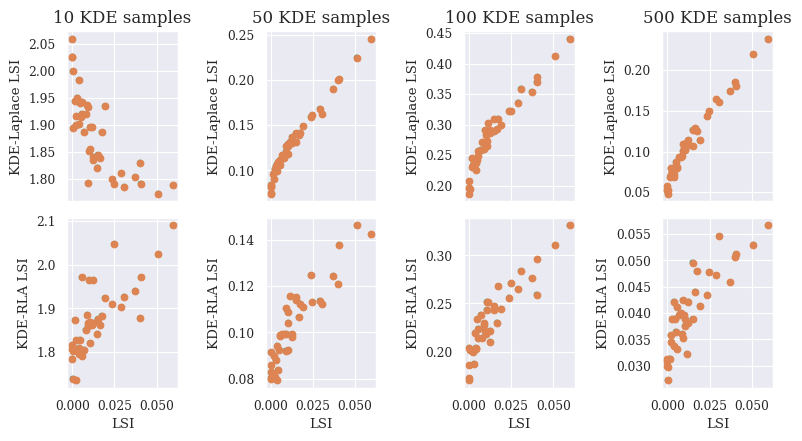

In [36]:
def sort_and_remove_upper_10(list1, list2, n):
    combined_lists = zip(list1, list2)
    sorted_combined = sorted(combined_lists, key=lambda x: x[0])
    sorted_list1, sorted_list2 = zip(*sorted_combined)
    if len(sorted_list1) > n:
        sorted_list1 = sorted_list1[:-n]
        sorted_list2 = sorted_list2[:-n]

    return sorted_list1, sorted_list2

import seaborn as sns
# Set Seaborn theme with paper context and font scale 2 (or 1.5)
sns.set_theme(context="paper", font_scale=2)

# Remove spines on every figure
sns.despine()

# Set colormap to "viridis" or another colorblind-friendly one
cmap = "viridis"

# Set minimum linewidth to 2
sns.set_context("paper", rc={"lines.linewidth": 2})

plt.rcParams.update({
    'font.family': 'serif',
})

def plot_subplots(data_dict):
    comps1 = [2, 2]
    comps2 = [0, 1]
    names = ["KDE-Laplace LSI", "KDE-RLA LSI", "LSI"]
    num_keys = len(data_dict)
    fig, axes = plt.subplots(2, num_keys, figsize=( 8, 4.5))
    
    for i, (key, value) in enumerate(data_dict.items()):
        for j, (comp1, comp2) in enumerate(zip(comps1, comps2)):
            ax = axes[j, i]
            value1, value2 = sort_and_remove_upper_10(value[comp1], value[comp2], 10)
            third = [1 for i in range(len(value1))]
            data = pd.DataFrame({'value1': value1, 'value2': value2, 'lab':third})
            sns.scatterplot(data=data, x='value1', y='value2', ax=ax, palette='viridis', hue="lab", legend=False)
            ax.scatter(value1, value2)
            if j != 0:
                ax.set_xlabel(names[comp1])
            else:
                ax.set_xlabel(None)
                ax.set_xticklabels([])
            ax.set_ylabel(names[comp2])
            if j == 0:
                ax.set_title(f'{key} KDE samples', fontsize=12)
            # else:
            #     ax.set_title(None)
    plt.rc('xtick', labelsize=8)
    plt.rc('ytick', labelsize=8)
    plt.rc('axes',  labelsize=8)
    plt.rc('axes',  titlesize=8)
    plt.tight_layout()
    save_dir = "/vol/aimspace/users/kaiserj/Individual_Privacy_Accounting/mimic_experiments/plot_functions_upd/results_new/"
    save_name = save_dir + "ablation_RLA_LA_LSI_larger_diff_longer"
    fig.savefig(save_name + ".pdf", format="pdf", dpi=1000)
    print(f"saving fig as {save_name}.pdf")
    plt.show()


plot_subplots(results)

In [47]:
import sys
sys.path.append('/vol/aimspace/users/kaiserj/Individual_Privacy_Accounting/mimic_experiments')
sys.path.append('/vol/aimspace/users/kaiserj')
from BayesDLL.methods.vi_binary import Runner
from Datasets.dataset_helper import get_dataset
import numpy as np
from laplace import Laplace
from utils.kl_div import _computeKL
import torch
from torch.utils.data import TensorDataset, DataLoader
import os
import pickle
import argparse
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import logging


def get_mean_and_prec(runner):
    a_std = list(runner.model._retrieve_s().parameters())
    a_mean = list(runner.model.m.parameters())
    l1_std = [params.view(-1).tolist() for params in a_std]
    l1_mean = [params.view(-1).tolist() for params in a_mean]
    l_std = []
    l_mean = []
    [l_std.extend(sublist) for sublist in l1_std]
    [l_mean.extend(sublist) for sublist in l1_mean]
    n_std = np.array(l_std)
    n_mean = np.array(l_mean)
    n_var = n_std**2
    n_prec = 1/n_var
    print(n_mean)
    return n_mean, n_prec

def kl_vi(n_remove):
    args = argparse.Namespace()
    args.pretrained = None
    args.lr = 0.05
    args.lr_head = args.lr
    args.hparams = {}
    args.hparams["prior_sig"]=1.0
    args.hparams["kld"]=1e-3
    args.hparams["bias"]="informative"
    args.hparams["nst"]=5
    args.ece_num_bins = 15
    args.epochs = 5000
    args.momentum = 0.0
    args.seed = 42
    args.test_eval_freq = 25
    args.log_dir = 'results'
    seed = args.seed
    args.device = "cpu"

    logging.basicConfig(
    handlers=[
        logging.FileHandler(os.path.join(args.log_dir, 'logs.txt')), 
        logging.StreamHandler()
    ], 
    format='[%(asctime)s,%(msecs)03d %(levelname)s] %(message)s',
    datefmt='%H:%M:%S',
    level=logging.INFO
    )
    logger = logging.getLogger()

    features_b = dataset.data.iloc[:, :-1].values
    labels_b = dataset.labels


    features = deepcopy(features_b)
    labels = deepcopy(labels_b)
    features = torch.tensor(features).type(torch.float32)
    labels = torch.tensor(labels).type(torch.float32)
    train_dataset = TensorDataset(features, labels)
    train_loader = DataLoader(train_dataset, batch_size=len(features), shuffle=False)
    args.ND = len(features)

    kl_seed = []
    idx_seed = []
    pred_seed = []
    kl = []
    torch.manual_seed(30)
    model = LogisticRegression(2)
    backup_model = deepcopy(model)

    for seed in range(5):
        torch.manual_seed(seed)
        rand_state = torch.random.get_rng_state()
        torch.random.set_rng_state(rand_state)
        X_train_rem = features # torch.cat([features[0:i], features[i+1:]])
        y_train_rem = labels # torch.cat([labels[0:i], labels[i+1:]])
        train_dataset_rem = TensorDataset(X_train_rem, y_train_rem)
        train_loader_rem = DataLoader(train_dataset_rem, batch_size=len(X_train_rem), shuffle=False)
        model = deepcopy(backup_model)
        model.readout_name = 'classifier'
        runner = Runner(model, None, args, logger, loss_fct)
        runner.train(train_loader_rem, train_loader_rem, train_loader_rem)
        n_mean, n_prec = get_mean_and_prec(runner)
        print(n_mean)
        print(n_prec)


        for i in tqdm(range(n_remove)):
            torch.manual_seed(seed)
            torch.random.set_rng_state(rand_state)
            X_train_rem = torch.cat([features[0:i], features[i+1:]])
            y_train_rem = torch.cat([labels[0:i], labels[i+1:]])
            train_dataset_rem = TensorDataset(X_train_rem, y_train_rem)
            train_loader_rem = DataLoader(train_dataset_rem, batch_size=len(X_train_rem), shuffle=False)
            model = deepcopy(backup_model)
            model.readout_name = 'classifier'
            runner = Runner(model, None, args, logger, loss_fct)
            runner.train(train_loader_rem, train_loader_rem, train_loader_rem)
            n_mean2, n_prec2 = get_mean_and_prec(runner)
            print(n_mean2)
            print(n_prec2)

            kl1, square_diff1 = _computeKL(n_mean, n_mean2, n_prec, n_prec2)
            # print(kl1)
            # print(square_diff1)
            kl_seed.append(kl1)
            idx_seed.append(i)
            print("")
        kl.append(kl_seed)
    return kl

kl = kl_vi(5)
for klx in kl:
    print(klx)

[15:25:33,090 INFO] Start training...


[15:25:40,292 INFO] Training done! Total time = 7.199589 (average per epoch = 0.001440) seconds


[ -5.15169191 -16.27779961]
[ -5.15169191 -16.27779961]
[0.0029294  0.00269653]


  0%|          | 0/5 [00:00<?, ?it/s][15:25:40,296 INFO] Start training...
[15:25:47,492 INFO] Training done! Total time = 7.195098 (average per epoch = 0.001439) seconds
 20%|██        | 1/5 [00:07<00:28,  7.20s/it][15:25:47,495 INFO] Start training...


[ -5.12628412 -16.25800323]
[ -5.12628412 -16.25800323]
[0.00292086 0.00271622]



[15:25:54,668 INFO] Training done! Total time = 7.172163 (average per epoch = 0.001434) seconds
 40%|████      | 2/5 [00:14<00:21,  7.19s/it][15:25:54,670 INFO] Start training...


[ -5.21456671 -16.10525513]
[ -5.21456671 -16.10525513]
[0.00288527 0.00269925]



[15:26:01,853 INFO] Training done! Total time = 7.182707 (average per epoch = 0.001437) seconds
 60%|██████    | 3/5 [00:21<00:14,  7.19s/it][15:26:01,857 INFO] Start training...


[ -4.72866058 -16.28622627]
[ -4.72866058 -16.28622627]
[0.00291468 0.00270895]



[15:26:09,043 INFO] Training done! Total time = 7.185680 (average per epoch = 0.001437) seconds
 80%|████████  | 4/5 [00:28<00:07,  7.19s/it][15:26:09,046 INFO] Start training...


[ -5.12518835 -16.22246361]
[ -5.12518835 -16.22246361]
[0.00289757 0.00271821]



[15:26:16,234 INFO] Training done! Total time = 7.187809 (average per epoch = 0.001438) seconds
100%|██████████| 5/5 [00:35<00:00,  7.19s/it]
[15:26:16,237 INFO] Start training...


[ -5.18972969 -16.10866165]
[ -5.18972969 -16.10866165]
[0.00287793 0.00269701]



[15:26:23,449 INFO] Training done! Total time = 7.210982 (average per epoch = 0.001442) seconds


[ -3.94143319 -16.02380371]
[ -3.94143319 -16.02380371]
[0.00254027 0.00291502]


  0%|          | 0/5 [00:00<?, ?it/s][15:26:23,451 INFO] Start training...
[15:26:30,646 INFO] Training done! Total time = 7.193805 (average per epoch = 0.001439) seconds
 20%|██        | 1/5 [00:07<00:28,  7.20s/it][15:26:30,648 INFO] Start training...


[ -3.9847436  -15.99443531]
[ -3.9847436  -15.99443531]
[0.00255807 0.00291929]



[15:26:37,865 INFO] Training done! Total time = 7.215896 (average per epoch = 0.001443) seconds
 40%|████      | 2/5 [00:14<00:21,  7.21s/it][15:26:37,871 INFO] Start training...


[ -3.98549843 -15.91479492]
[ -3.98549843 -15.91479492]
[0.00259133 0.00289399]



[15:26:45,056 INFO] Training done! Total time = 7.183625 (average per epoch = 0.001437) seconds
 60%|██████    | 3/5 [00:21<00:14,  7.20s/it][15:26:45,059 INFO] Start training...


[ -3.97963548 -15.92530251]
[ -3.97963548 -15.92530251]
[0.00254646 0.00290939]



[15:26:52,255 INFO] Training done! Total time = 7.195807 (average per epoch = 0.001439) seconds
 80%|████████  | 4/5 [00:28<00:07,  7.20s/it][15:26:52,258 INFO] Start training...


[ -3.97675705 -15.95101261]
[ -3.97675705 -15.95101261]
[0.00255538 0.00292161]



[15:26:59,484 INFO] Training done! Total time = 7.225697 (average per epoch = 0.001445) seconds
100%|██████████| 5/5 [00:36<00:00,  7.21s/it]
[15:26:59,488 INFO] Start training...


[ -3.98331213 -15.92680645]
[ -3.98331213 -15.92680645]
[0.00256384 0.00289864]



[15:27:06,717 INFO] Training done! Total time = 7.228736 (average per epoch = 0.001446) seconds


[ -5.47021103 -16.427145  ]
[ -5.47021103 -16.427145  ]
[0.00310937 0.00281016]


  0%|          | 0/5 [00:00<?, ?it/s][15:27:06,720 INFO] Start training...
[15:27:13,922 INFO] Training done! Total time = 7.201237 (average per epoch = 0.001440) seconds
 20%|██        | 1/5 [00:07<00:28,  7.20s/it][15:27:13,924 INFO] Start training...


[ -5.24696207 -16.25342369]
[ -5.24696207 -16.25342369]
[0.00293461 0.00284572]



[15:27:21,142 INFO] Training done! Total time = 7.216730 (average per epoch = 0.001443) seconds
 40%|████      | 2/5 [00:14<00:21,  7.21s/it][15:27:21,145 INFO] Start training...


[ -5.6125412  -16.24468613]
[ -5.6125412  -16.24468613]
[0.0030473  0.00282166]



[15:27:28,355 INFO] Training done! Total time = 7.210089 (average per epoch = 0.001442) seconds
 60%|██████    | 3/5 [00:21<00:14,  7.21s/it][15:27:28,358 INFO] Start training...


[ -5.27198029 -16.30106163]
[ -5.27198029 -16.30106163]
[0.00299029 0.00282979]



[15:27:35,577 INFO] Training done! Total time = 7.218514 (average per epoch = 0.001444) seconds
 80%|████████  | 4/5 [00:28<00:07,  7.22s/it][15:27:35,579 INFO] Start training...


[ -5.34986973 -16.23677635]
[ -5.34986973 -16.23677635]
[0.00295904 0.00284854]



[15:27:42,796 INFO] Training done! Total time = 7.215874 (average per epoch = 0.001443) seconds
100%|██████████| 5/5 [00:36<00:00,  7.22s/it]
[15:27:42,802 INFO] Start training...


[ -5.66900635 -16.25108337]
[ -5.66900635 -16.25108337]
[0.00308606 0.00279754]



[15:27:49,998 INFO] Training done! Total time = 7.195308 (average per epoch = 0.001439) seconds


[ -4.94547558 -16.23948669]
[ -4.94547558 -16.23948669]
[0.00293934 0.00267596]


  0%|          | 0/5 [00:00<?, ?it/s][15:27:50,003 INFO] Start training...
[15:27:57,186 INFO] Training done! Total time = 7.183059 (average per epoch = 0.001437) seconds
 20%|██        | 1/5 [00:07<00:28,  7.19s/it][15:27:57,189 INFO] Start training...


[ -4.67030907 -16.27377701]
[ -4.67030907 -16.27377701]
[0.0029778  0.00269137]



[15:28:04,369 INFO] Training done! Total time = 7.180115 (average per epoch = 0.001436) seconds
 40%|████      | 2/5 [00:14<00:21,  7.18s/it][15:28:04,372 INFO] Start training...


[ -5.29648066 -16.21559525]
[ -5.29648066 -16.21559525]
[0.00311252 0.00265815]



[15:28:11,564 INFO] Training done! Total time = 7.191099 (average per epoch = 0.001438) seconds
 60%|██████    | 3/5 [00:21<00:14,  7.19s/it][15:28:11,566 INFO] Start training...


[ -5.0060997  -16.30891037]
[ -5.0060997  -16.30891037]
[0.00309454 0.00265927]



[15:28:18,752 INFO] Training done! Total time = 7.184983 (average per epoch = 0.001437) seconds
 80%|████████  | 4/5 [00:28<00:07,  7.19s/it][15:28:18,754 INFO] Start training...


[ -4.82475519 -15.99704742]
[ -4.82475519 -15.99704742]
[0.00295058 0.00255754]



[15:28:25,946 INFO] Training done! Total time = 7.190840 (average per epoch = 0.001438) seconds
100%|██████████| 5/5 [00:35<00:00,  7.19s/it]
[15:28:25,949 INFO] Start training...


[ -5.26886559 -16.22131348]
[ -5.26886559 -16.22131348]
[0.00309868 0.00264874]



[15:28:33,151 INFO] Training done! Total time = 7.201647 (average per epoch = 0.001440) seconds


[ -4.59820986 -15.40008926]
[ -4.59820986 -15.40008926]
[0.00274546 0.00234593]


  0%|          | 0/5 [00:00<?, ?it/s][15:28:33,154 INFO] Start training...
[15:28:40,327 INFO] Training done! Total time = 7.171605 (average per epoch = 0.001434) seconds
 20%|██        | 1/5 [00:07<00:28,  7.17s/it][15:28:40,329 INFO] Start training...


[ -4.19777536 -15.45283318]
[ -4.19777536 -15.45283318]
[0.00278558 0.00236416]



[15:28:47,510 INFO] Training done! Total time = 7.180492 (average per epoch = 0.001436) seconds
 40%|████      | 2/5 [00:14<00:21,  7.18s/it][15:28:47,517 INFO] Start training...


[ -4.54813147 -15.33451748]
[ -4.54813147 -15.33451748]
[0.00284071 0.00234194]



[15:28:54,707 INFO] Training done! Total time = 7.190135 (average per epoch = 0.001438) seconds
 60%|██████    | 3/5 [00:21<00:14,  7.19s/it][15:28:54,711 INFO] Start training...


[ -4.6004715  -15.37630939]
[ -4.6004715  -15.37630939]
[0.00280732 0.00234877]



[15:29:01,883 INFO] Training done! Total time = 7.171235 (average per epoch = 0.001434) seconds
 80%|████████  | 4/5 [00:28<00:07,  7.18s/it][15:29:01,885 INFO] Start training...


[ -4.39200544 -15.45290947]
[ -4.39200544 -15.45290947]
[0.00286586 0.00235222]



[15:29:09,061 INFO] Training done! Total time = 7.174952 (average per epoch = 0.001435) seconds
100%|██████████| 5/5 [00:35<00:00,  7.18s/it]

[ -3.99128985 -15.35268879]
[ -3.99128985 -15.35268879]
[0.00278835 0.00233385]

[1.6865433097267706897e-05, 0.000103433781493190036366, 0.00027251011553059215076, 5.0974560591762752004e-05, 0.000118761790519120863374, 1.6412588407596021695e-05, 0.00013247605897242402742, 1.8391318593986676067e-05, 1.942377946796951943e-05, 4.520720158879536904e-05, 0.00097646629841959247526, 0.00018298463494191390122, 0.00046974272409824662997, 0.00072317398371745137894, 0.00012351698409666586609, 0.00016500449041605093001, 0.001038856156890421989, 0.0006952832864977457651, 0.00060480592975903748124, 0.0008977041993050946002, 0.0002945251162038229481, 0.000303439722076213024, 0.0001260815242731493091, 0.0005331701579412550379, 0.00058319505545351623885]
[1.6865433097267706897e-05, 0.000103433781493190036366, 0.00027251011553059215076, 5.0974560591762752004e-05, 0.000118761790519120863374, 1.6412588407596021695e-05, 0.00013247605897242402742, 1.8391318593986676067e-05, 1.942377946796951943e-05, 4.52072

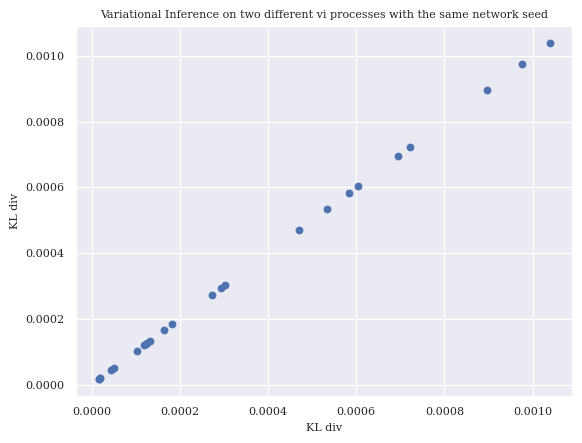

In [48]:
import matplotlib.pyplot as plt

list1 = kl[0] # [70.18440032015748102, 18.005079326076625845, 70.12340246981835814, 0.022996015171340570063, 0.2078847475730550434, 70.117928300858142175, 39.493317145626001985, 2.3557196169959917892, 2.3552206319762256312, 2.354889201025052495, 7.400724009374454093, 0.25992671906253449204, 0.20350637633025780917, 2.3554001805403190258, 70.08330113982599133, 0.04218437274299339585, 70.14223372449931981, 70.282562083321728566, 0.5536745538695789992, 2.3554557879374062865, 0.02575724048969407526, 70.14487351870440505, 2.355474637502777823, 2.3556191464882533582, 69.77840076677369658, 70.17934441704335524, 2.355186059304031466, 69.899987677735712345, 70.04448169163770304, 2.3548678058632856267, 70.08701082909674102, 2.3551694633195861042, 0.6813677140875961011, 2.3552716639227654486, 2.3372152539291054267, 25.095744741598277144, 0.1825570466587178994, 0.20587277454649961387, 70.16623602378627282, 7.3343160755812095305, 0.2046764971359139596, 17.59358185095613048, 70.06113558476678809, 0.022626802418873938035, 0.20891791562885516872, 2.3550814145383586438, 70.0708267313369982, 2.3535265569827231152, 0.2376928756764181573, 70.149458210605275976]
list2 = kl[1] # [8.321726310723710098, 2.2825570750003104032, 0.44885816676463878713, 2.3904027810578971237, 2.4075915043834176426, 0.18214099119869466491, 0.16990514259568898154, 2.3763078869200475237, 8.390719092339370774, 0.76201711782489596773, 86.07613332364214691, 123.73630189006762927, 0.15351759152792316982, 0.009159192025517734221, 0.52090167085886701723, 3.7083953949458853755, 47.629742049143371136, 0.49199643127787617174, 0.16367042273747516566, 2.0579553031294184288, 105.64179042222295393, 0.23278798663304048496, 2.298216151839305724, 0.14650012006812514523, 0.18451945780480906022, 319.9378108987343173, 0.39562440316640668273, 2.5842592422458807388, 0.33669072354223388932, 0.7712196380178704486, 0.0039454843742018443943, 2.3399266462644183998, 2.1198835217619003413, 22.851817835738321717, 60.813772844160846477, 1.8032080943315571486, 2.0702328044135203584, 0.62874401544926023855, 4.775480943427378998, 112.58828876384917901, 2.4075611884878871693, 74.9839740969022449, 66.18719064582453712, 28.427475632926803373, 12.5801752018031038115, 47.874647367637284626, 0.003637042673817838601, 38.268168398817371645, 21.198376782612746843, 91.472419082732581985]

plt.scatter(list1, list2)

# Add labels and title
plt.xlabel('KL div')
plt.ylabel('KL div')
plt.title('Variational Inference on two different vi processes with the same network seed')

# Display the plot
plt.show()